![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
estadisticas_precios = data['Price'].describe()
estadisticas_precios

count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1

def mse(y):
    return np.mean((y - np.mean(y))**2)

def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y[filter_l]
    y_r = y[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    if n_l == 0 or n_r == 0:
        return 0
    mse_total = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    mse_reduction = mse_total - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    return mse_reduction

def best_split(X, y, num_pct=10):
    features = X.columns
    best_split = [None, 0, -np.inf]  # feature, split, gain
    for feature in features:
        X_col = X[feature]
        if X_col.dtype in [np.int64, np.float64]:
            values = np.unique(X_col)
            splits = np.percentile(values, np.linspace(0, 100, min(num_pct+1, len(values))))
            for split in splits:
                gain = mse_impurity(X_col, y, split)
                if gain > best_split[2]:
                    best_split = [feature, split, gain]
    return best_split

# Encontrar la mejor división
feature, split, gain = best_split(X_train, y_train)
print(f'Best split: {feature}, at {split}, with gain {gain}')

# Aplicar la división
X_train_split = X_train[feature] < split
X_test_split = X_test[feature] < split

# Predicciones simplificadas como la media de los precios en cada lado de la división
y_train_pred = np.where(X_train_split, y_train[X_train_split].mean(), y_train[~X_train_split].mean())
y_test_pred = np.where(X_test_split, y_train[X_train_split].mean(), y_train[~X_train_split].mean())

# Calcular RMSE y MAE para el conjunto de test
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

Best split: Year, at 2012.3, with gain 8790046.173046965
RMSE: 2552.265051523914
MAE: 1977.6071801131102


In [ ]:
def tree_grow(X, y, level=0, max_depth=3, min_samples_split=10, num_pct=10):
    if len(X) < min_samples_split or level == max_depth:
        return {'y_pred': y.mean(), 'level': level}  # Nodo hoja
    else:
        # Encontrar la mejor división
        feature, split, gain = best_split(X, y, num_pct)
        if gain == -np.inf:
            return {'y_pred': y.mean(), 'level': level}  # Nodo hoja
        X_left = X[X[feature] < split]
        y_left = y[X[feature] < split]
        X_right = X[X[feature] >= split]
        y_right = y[X[feature] >= split]

        # Crear sub-árbol a la izquierda y derecha
        left_tree = tree_grow(X_left, y_left, level + 1, max_depth, min_samples_split, num_pct)
        right_tree = tree_grow(X_right, y_right, level + 1, max_depth, min_samples_split, num_pct)

        return {'feature': feature, 'split': split, 'gain': gain, 'left': left_tree, 'right': right_tree, 'level': level}
# Árbol
tree = tree_grow(X_train, y_train, max_depth=3)
tree

{'feature': 'Year',
 'split': 2012.3,
 'gain': 8790046.173046965,
 'left': {'feature': 'Year',
  'split': 2012.0,
  'gain': 2959465.8517095316,
  'left': {'feature': 'Mileage',
   'split': 101164.5,
   'gain': 1149468.9748928966,
   'left': {'y_pred': 9810.149725274725, 'level': 3},
   'right': {'y_pred': 7665.883401920439, 'level': 3},
   'level': 2},
  'right': {'feature': 'Mileage',
   'split': 79458.0,
   'gain': 1291249.4076021155,
   'left': {'y_pred': 13578.11935483871, 'level': 3},
   'right': {'y_pred': 11257.839805825242, 'level': 3},
   'level': 2},
  'level': 1},
 'right': {'feature': 'Year',
  'split': 2017.0,
  'gain': 1620597.6461158656,
  'left': {'feature': 'Mileage',
   'split': 50852.40000000001,
   'gain': 893550.675860357,
   'left': {'y_pred': 16256.664415736936, 'level': 3},
   'right': {'y_pred': 13863.638922888616, 'level': 3},
   'level': 2},
  'right': {'feature': 'Year',
   'split': 2018.0,
   'gain': 750065.9110053903,
   'left': {'y_pred': 19105.5256097560

In [ ]:
def print_tree(tree, depth=0):
    base_indent = "    " * depth
    if 'split' not in tree:
        print(f"{base_indent}Leaf: Predict = {tree['y_pred']:.2f}")
    else:
        print(f"{base_indent}[Level {tree['level']}] Split at {tree['feature']} <= {tree['split']:.2f} with gain {tree['gain']:.2f}")
        print_tree(tree['left'], depth + 1)
        print_tree(tree['right'], depth + 1)

# Imprimir el árbol
print_tree(tree)


[Level 0] Split at Year <= 2012.30 with gain 8790046.17
    [Level 1] Split at Year <= 2012.00 with gain 2959465.85
        [Level 2] Split at Mileage <= 101164.50 with gain 1149468.97
            Leaf: Predict = 9810.15
            Leaf: Predict = 7665.88
        [Level 2] Split at Mileage <= 79458.00 with gain 1291249.41
            Leaf: Predict = 13578.12
            Leaf: Predict = 11257.84
    [Level 1] Split at Year <= 2017.00 with gain 1620597.65
        [Level 2] Split at Mileage <= 50852.40 with gain 893550.68
            Leaf: Predict = 16256.66
            Leaf: Predict = 13863.64
        [Level 2] Split at Year <= 2018.00 with gain 750065.91
            Leaf: Predict = 19105.53
            Leaf: Predict = 25626.07


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:

# Celda 2
import numpy as np
from sklearn.utils import resample

def bagging_trees(X, y, n_trees, max_depth=3):
    trees = []
    for i in range(n_trees):
        X_sample, y_sample = resample(X, y)  # Bootstrap sample
        tree = tree_grow(X_sample, y_sample, max_depth=max_depth)
        trees.append(tree)
    return trees

# Entrenar 10 árboles de regresión
n_trees = 10
trees = bagging_trees(X_train, y_train, n_trees, max_depth=3)


In [ ]:
def tree_predict(X, tree):
    # Chequear si estamos en un nodo hoja
    if 'split' not in tree:
        return np.array([tree['y_pred']] * len(X))  # Retornar la predicción de la hoja para todas las entradas

    # Si no es un nodo hoja, proceder a dividir los datos
    feature, split = tree['feature'], tree['split']
    left_indices = X[feature] < split  # Indices para la rama izquierda
    right_indices = ~left_indices  # Indices para la rama derecha

    # Inicializar un arreglo para almacenar las predicciones
    predictions = np.zeros(len(X))

    # Recursivamente predecir para cada lado del árbol
    if tree['left']:  # Chequear si hay una subrama a la izquierda
        predictions[left_indices] = tree_predict(X[left_indices], tree['left'])
    if tree['right']:  # Chequear si hay una subrama a la derecha
        predictions[right_indices] = tree_predict(X[right_indices], tree['right'])

    return predictions


def predict_bagging(trees, X):
    # Calcula predicciones de todos los árboles
    predictions = np.array([tree_predict(X, tree) for tree in trees])
    # Promedia las predicciones
    return np.mean(predictions, axis=0)

# Predicciones en el conjunto de test
y_pred_test = predict_bagging(trees, X_test)

# Calcular RMSE y MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 1834.2631895924828
MAE: 1369.7727591174605


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Definir el modelo Bagging
bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=int(np.log2(X.shape[1])),
    random_state=42
)

# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = bagging_model.predict(X_test)

# MSE y R2 para evaluar el desempeño del modelo
mse = mean_squared_error(y_test, y_pred)
r2_score = bagging_model.score(X_test, y_test)
rmse=np.sqrt(mse)

print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación R^2: {r2_score}')
print(f'RMSE: {rmse}')

Error cuadrático medio (MSE): 5171694.547713897
Coeficiente de determinación R^2: 0.6618955768695581
RMSE: 2274.1360002677716


Un R^2 de 0.708 significa que aproximadamente el 70.8% de la variación en el precio del automóvil puede ser explicada por el modelo de bagging.

El MSE de 4456486 es considerablemente más alto que la media de los precios, lo que indica que los errores de predicción son, en promedio, substanciales.

El RMSE es un poco más de la mitad de la desviación estándar de los precios. Esto significa que el error estándar de las predicciones del modelo es menor que la variabilidad natural de los precios, lo cual es positivo.

En conclusión, el modelo de Bagging parece capturar una cantidad significativa de la variabilidad en los precios de los automóviles, aunque con un error de predicción promedio notable. Sería conveniente explorar maneras de reducir este error. A pesar de que el MSE parece alto, el coeficiente R2 de 0.708 sugiere que el modelo es capaz de explicar aproximadamente el 70.8% de la variación de los precios, lo cual es una indicación de un ajuste relativamente bueno.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


# Crear y entrenar el modelo de Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred = random_forest_model.predict(X_test)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse=np.sqrt(mse)

# Mostrar el desempeño del modelo
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R^2): {r2}')
print(f'RMSE: {rmse}')

Error cuadrático medio (MSE): 3116678.915374798
Coeficiente de determinación (R^2): 0.7962441677396794
RMSE: 1765.4118259983413


Un R^2 de 0.796 indica que el modelo puede explicar aproximadamente el 79.6% de la variación en los precios de los automóviles, lo que es generalmente un buen resultado, indicando que el modelo tiene una capacidad predictiva bastante alta.

Si lo comparamos con la desviación estándar, el RMSE es aproximadamente el 45% de la desviación estándar. Esto sugiere que los errores del modelo son menores que la mitad de la variabilidad estándar de los precios de los automóviles, lo cual es favorable

Comparado con la media (14538 dólares), el RMSE es aproximadamente el 12.14% de esta cantidad. Esto significa que el error típico de las predicciones del modelo es un poco más que una décima parte del precio medio de un coche, lo cual puede considerarse razonable dependiendo del uso del modelo.




### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

A continuación se realiza la calibración del parametro **'max_depth'** este parametro controla la profundidad máxima de los árboles.Profundidades más profundas pueden capturar relaciones más complejas pero pueden llevar a sobreajuste mientras que profundidades más superficiales pueden simplificar el modelo pero pueden perder relaciones complejas.

In [ ]:
# Calibración de max_depth
depth_range = range(1, 21)  # Rango de valores para max_depth

# Lista para almacenar el error cuadrático medio (MSE) promedio para cada valor de max_depth
mse_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestRegressor(n_estimators=200, max_depth=depth, random_state=1, n_jobs=-1)
    mse_scores_depth.append(-1 * cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean())

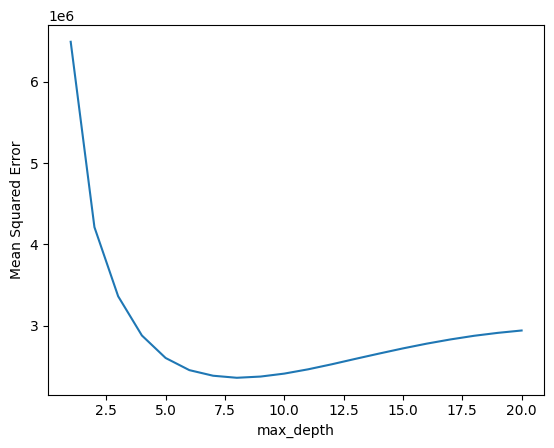

8

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, mse_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.show()
best_depth = depth_range[np.argmin(mse_scores_depth)]
best_depth


A continuación se realiza la calibración del parametro **'max_features'** este parametro controla el número máximo de variables consideradas para dividir un nodo. Más variables pueden hacer el modelo más robusto pero pueden aumentar la complejidad mientras que menos variables pueden simplificar el modelo pero pueden reducir su capacidad predictiva.

In [ ]:
# Calibración de max_features
feature_cols = X.columns
feature_range = range(1, len(feature_cols) + 1)  # Rango de valores para max_features

# Lista para almacenar el error cuadrático medio (MSE) promedio para cada valor de max_features
mse_scores_features = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    mse_scores_features.append(-1 * cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean())

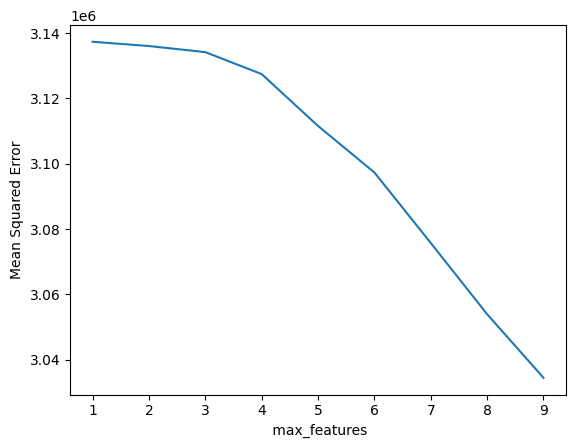

9

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(feature_range, mse_scores_features)
plt.xlabel(' max_features')
plt.ylabel('Mean Squared Error')
plt.show()
best_feature = feature_range[np.argmin(mse_scores_features)]
best_feature

A continuación se realiza la calibración del parametro **'n_estimators'** este parametro indica la cantidad de árboles que se tendrá que construir. A medida que el parámetro aumenta de valor, mejora el desempeño del modelo, sin embargo, en un punto ya no se presenta ninguna mejora adicional.

In [ ]:
# Calibración de n_estimators
estimator_range = range(10, 310, 10)  # Rango de valores para n_estimators

# Lista para almacenar el error cuadrático medio (MSE) promedio para cada valor de n_estimators
mse_scores_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, max_depth=None, max_features='auto', random_state=1, n_jobs=-1)
    mse_scores_estimators.append(-1 * cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean())


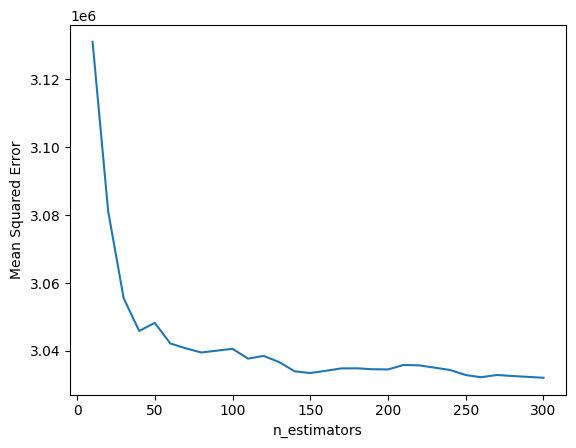

300

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()
best_estimators = estimator_range[np.argmin(mse_scores_estimators)]
best_estimators

In [ ]:
# Definición del modelo con los mejores parámetros
clf_rfc = RandomForestRegressor(n_estimators=best_estimators,
                             max_depth=best_depth
,
                             max_features=best_feature,
                             random_state=1,
                             n_jobs=-1)

# Entrenamiento del modelo
clf_rfc.fit(X_train, y_train)
y_pred = clf_rfc.predict(X_test)
# Calcular métricas de rendimiento
mse_rfc = mean_squared_error(y_test, y_pred)
r2_rfc = r2_score(y_test, y_pred)
rmse_rfc=np.sqrt(mse_rfc)

# Mostrar el desempeño del modelo
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R^2): {r2}')
print(f'RMSE: {rmse_rfc}')

Error cuadrático medio (MSE): 3116678.915374798
Coeficiente de determinación (R^2): 0.7962441677396794
RMSE: 1565.0162673115353


Comparando estos resultados del modelo de random forest sin calibrar con el anterior, se puede decir que

El **MSE** del modelo calibrado (2449275.9) es menor que el MSE del modelo original (3116678.9), lo que indica que el modelo calibrado tiene un mejor ajuste a los datos de prueba.

El coeficiente de determinación **R^2** del modelo calibrado (0.83) es mayor que el R^2 del modelo original (0.796), lo que sugiere que el modelo calibrado explica una mayor proporción de la varianza en los datos de prueba.

El **RMSE** del modelo calibrado (1565.01) es menor que el RMSE del modelo original (1765.41), lo que indica que el modelo calibrado tiene un error de predicción medio más bajo en los datos de prueba.

Tendiendo en estas métricas, se puede concluir que el modelo Random Forest calibrado tiene un mejor desempeño que el modelo original, ya que tiene un rendimiento superior en todas las métricas evaluadas.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
clf = XGBRegressor()
clf

# Entrenamiento (fit) y desempeño del modelo XGBRegressor
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calcular el error cuadrático medio y r cuadrado
mse_xgboost1 = mean_squared_error(y_test, y_pred)
r2_xgboost1 = r2_score(y_test, y_pred)
rmse_xgboost1=np.sqrt(mse_xgboost1)

print("Error cuadrático medio xboost inicial:", mse_xgboost1)
print(f'Coeficiente de determinación (R^2) xgboost inicial: {r2_xgboost1}')
print(f'RMSE: {rmse_xgboost1}')

Error cuadrático medio xboost inicial: 2576781.074646859
Coeficiente de determinación (R^2) xgboost inicial: 0.8315404997841507
RMSE: 1605.2355199928948



Con el modelo XGBoost utilizando los parámetros predeterminados proporcionados por el paquete sklearn, se obtienen los siguientes resultados:

El coeficiente de determinación $R^2$ es notablemente alto (0.83), lo que sugiere que el modelo explica aproximadamente el 83% de la variabilidad de los datos, lo cual es bastante satisfactorio.

El Error Cuadrático Medio Raíz (RMSE) proporciona una medida de la diferencia promedio entre las predicciones del modelo y los valores reales. En este caso, el RMSE es aproximadamente 1605.23, lo que indica que las predicciones del modelo están desviadas en promedio por esa cantidad de la variable objetivo.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'gamma': [0, 0.1, 0.3, 0.5, 0.7],
    'colsample_bytree': [0.2, 0.5, 0.7, 1.0]
}

model = XGBRegressor()

# Ejecución de un grid search para buscar los mejores parametros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

# Xgboost para regresión con los mejores parametros
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluación en la base de test
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio y r cuadrado
mse_xgboost2 = mean_squared_error(y_test, y_pred)
r2_xgboost2 = r2_score(y_test, y_pred)
rmse_xgboost2=np.sqrt(mse_xgboost2)

print("Error cuadrático medio xgboost parametros:", mse_xgboost2)
print(f'Coeficiente de determinación (R^2) xgboost parametros: {r2_xgboost2}')
print(f'RMSE: {rmse_xgboost2}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
Error cuadrático medio xgboost parametros: 2399172.6520076604
Coeficiente de determinación (R^2) xgboost parametros: 0.843151818419757
RMSE: 1548.926290049872


Se realiza una grilla de parametros con learning rate, gamma y colsample_bytree.

* **Learning rate:** El "learning rate" es como la velocidad a la que un algoritmo de aprendizaje automático "aprende" de los datos. Si es demasiado alto, puede "saltar" sobre la solución óptima. Si es demasiado bajo, puede llevar mucho tiempo llegar a la solución correcta. En resumen, es un ajuste importante para equilibrar entre la velocidad y la precisión del aprendizaje automático.
* **Gamma:** La reducción mínima de pérdida requerida para realizar una partición adicional en un nodo hoja del árbol. Cuanto mayor sea el valor de gamma, más conservador será el algoritmo.
* **colsample_bytree:** Es un parámetro que controla la proporción de características (columnas) que se utilizarán al construir cada árbol. Un valor bajo de colsample_bytree significa que se seleccionará una proporción menor de características para construir cada árbol, lo que puede ayudar a reducir el sobreajuste y mejorar la generalización del modelo. Por otro lado, un valor alto de colsample_bytree significa que se utilizará una proporción mayor de características, lo que puede resultar en un modelo más complejo y propenso al sobreajuste.

La grilla nos arroja que los mejores parametros son los siguientes: Learning_rate= 0.1, colsample_bytree=0.5 y gamma=0, con el que obtenemos los siguientes resultados

El r cuadrado es bastante alto (0.84), lo que sugiere que el modelo explica aproximadamente el 84% de la variabilidad de los datos, lo cual es bastante bueno.

El RMSE proporciona una medida de cuánto se desvían, en promedio, las predicciones del modelo de los valores reales. En este caso, el RMSE es aproximadamente 1548.93, lo que significa que, en promedio, las predicciones del modelo están desviadas por esa cantidad de la variable objetivo.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

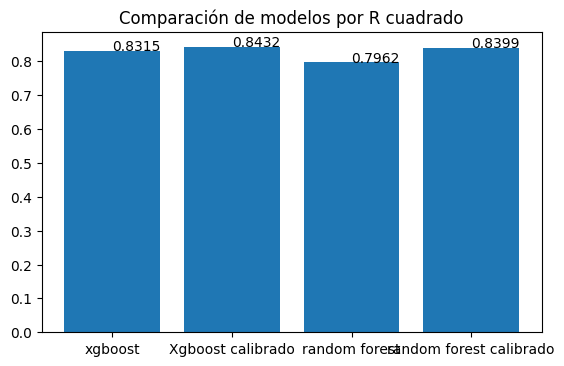

In [ ]:
# Celda 8
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por R cuadrado")
ejeX = ['xgboost','Xgboost calibrado', 'RF', 'RF calibrado']
ejeY = [round(r2_xgboost1,4),round(r2_xgboost2,4),round(r2,4),round(r2_rfc,4) ]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

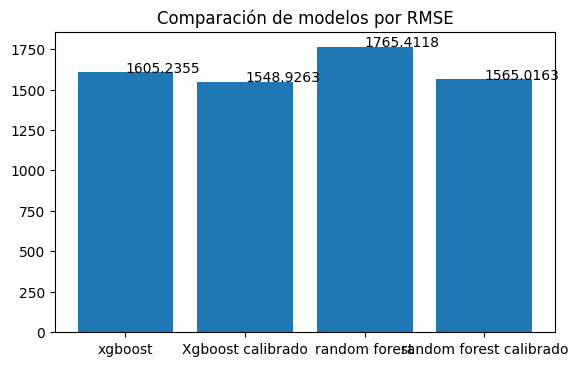

In [ ]:
# Celda 8
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por RMSE")
ejeX = ['xgboost','Xgboost calibrado', 'RF', 'RF calibrado']
ejeY = [round(rmse_xgboost1,4),round(rmse_xgboost2,4),round(rmse,4),round(rmse_rfc,4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()


Los resultados de las gráficas anteriores indican que calibrar cualquiera de los dos modelos produce mejoras significativas en comparación con no realizar ninguna calibración. En este caso, el XGBoost muestra el coeficiente de determinación $R^2$ más alto, con una diferencia mínima en comparación con el Random Forest calibrado. Asimismo, en términos de RMSE, observamos un comportamiento similar. Estos hallazgos nos llevan a concluir que el XGBoost calibrado es el modelo preferido para predecir el valor de un automóvil